## Setup
# PCA Cifar 2

In [7]:
##
## Restrict tensorflow to single GPU
##
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)           
## this says only use GPU 0  (can select 0-3)

##
## Import libraries
##
import evm_flat         ## We are using EVMs for a different project, so there are some things in here that may be confusing
from utils import *     ## utils holds a few functions I wrote to help with the experiments in this notebook
import numpy as np
import tensorflow as tf

##
## Experiment Parameters
##
epochs = 10               ## Iterations to train CNN for feature extractors
num_to_remove = 2           ## Number of classes to remove and make "unknown"
iterations = 30              ## Number of iterations (full experiments) to run
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  ## Confidence thresholds to evaluate over

##
## EVM Parameters (good initial values, but could be further optimized)
##
tailsize = 10000              ## EVM tail size
cover_threshold = 0.5      ## EVM cover threshold
dist_func = 'cosine'     ## EVM distance function
num_to_fuse = 4             ## EVM number to fuse
margin_scale = 0.5          ## EVM margin scale

## Data

In [8]:
##
## Load CiFar10
##
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
##
## Get data in correct shape and normalize
##
#x_train = x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))/255.0   ## Add dimension and normalize
#x_test = x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))/255.0         ## Add dimension and normalize
#y_train = tf.keras.utils.to_categorical(y_train)     ## Make one-hot
#y_test = tf.keras.utils.to_categorical(y_test)       ## Make one-hot

(50000, 32, 32, 3)


In [9]:
import keras.utils
y_train = tf.keras.utils.to_categorical(y_train) #one hot encode y vectors
y_test = tf.keras.utils.to_categorical(y_test)

y_train.shape

(50000, 10)

In [10]:
import random

shrink_x_train = np.asarray(x_train)
print(shrink_x_train.shape)
x_train_for_fit_index = np.random.choice(len(shrink_x_train), size = 15000, replace = False, p = None)

x_train_for_fit = shrink_x_train[x_train_for_fit_index]
x_train_for_fit.shape

(50000, 32, 32, 3)


(15000, 32, 32, 3)

## Create Feature Extractor With Perfect Knowledge 

- Feature extractor is a CNN trained using ALL of the classes
- This is not realistic in the real world because all of the classes will not be known
- This is a good "optimal" feature space to compare against
- Goal would be to get as close to this performance as possible

In [11]:
##
## Perfect Knowledge feature extractor
##
import plotly.express as plotex
from sklearn.decomposition import PCA


x_train_flattened = x_train_for_fit.reshape(15000,3072) #reshaping cube arrays into a flat vector 
#perfect_pca = PCA(svd_solver = 'full') #needs to be changed potentially with fancy graph information
perfect_pca = PCA(n_components = 128)
perfect_pca.fit(x_train_flattened)


exp_var_cumul = np.cumsum(perfect_pca.explained_variance_ratio_)

#print(exp_var_cumul)
#print(perfect_pca.explained_variance_ratio_)

#plotex.area(
#    x=range(1, exp_var_cumul.shape[0] + 1),
 #   y=exp_var_cumul,
  #  labels={"x": "# Components", "y": "Explained Variance"}
#)
#perfect_pca_features = perfect_pca.transform(x_train_flattened) #pca.transform(x_test.reshape(y, 3072)) <--- that would be testing for EVM 

In [12]:
#samp = [[.6], [.65], [.7]]
#pca_found = False
#index = 0 

#pca_index_list =[]

#print(exp_var_cumul.dtype)
#iter_exp_var_cumul = [exp_var_cumul]
#print(iter_exp_var_cumul)
#while pca_found == False:
#    for val in iter_exp_var_cumul:
#        for value in val:
#            index += 1
#            #print(value)
 #           if value > .9:
 #               pca_num = index - 1
 #               pca_index_list.append(pca_num)
#                #pca_found = True
#                print(pca_index_list[1])
                
            

In [13]:
#print(exp_var_cumul.dtype)
iter_exp_var_cumul = [exp_var_cumul]
#print(iter_exp_var_cumul)
index = -1

for val in iter_exp_var_cumul:
    for value in val:
        index += 1
        #print(value)
        if index == 127:
            print("128?")
            #pca_num = index - 1
            #pca_index_list.append(pca_num)
            #pca_found = True
            print(value)

128?
0.9195438179768411


## Define a set of experiments

- Randomly select and remove classes from the training data
- Split test data into known and unknown classes
- Fit imperfect feature extraction model
- Extract features using the perfect and imperfect extractors
- Fit EVM using features for the perfect and imperfect
- Evaluate performance (evaluation metrics may need to be improved, but this gives us an initial idea of performance)
- Repeat


In [14]:
##
import pandas as pd
## Define places to store results
##
imp_known_correct_all = []
imp_known_novel_all = []
imp_unknown_correct_all = []
imp_unknown_novel_all = []
per_known_correct_all = []
per_known_novel_all = []
per_unknown_correct_all = []
per_unknown_novel_all = []

df = pd.DataFrame(columns=['Iteration', 'Unknown Classes', 'imp_known_correct_all', 'imp_known_novel_all', 'imp_unknown_novel_all','per_known_correct_all','per_known_novel_all','per_unknown_novel_all'])

##
## Begin experiments
## imperfect cnn starts here
for i in range(iterations):
    print('Iteration: ' + str(i))
    print()
    
    ##
    ## Split the data into known and unknown classes
    ##
    toRemove = np.random.choice(10, num_to_remove, replace = False)                                         ## Randomly pick unknown classes
    x_train_known, x_train_unknown, y_train_known, y_train_unknown = split_data(x_train, y_train, toRemove) ## Split train data (defined in utils.py)
    x_test_known, x_test_unknown, y_test_known, y_test_unknown = split_data(x_test, y_test, toRemove)       ## Split test data (defined in utils.py)
   
    ##
    #df = df.append({'Iteration':i, 'Unknown Classes': toRemove}, ignore_index=True)
    #df.to_csv(r'./pca_df.csv', index=False,header=True)
    ## Train a classifier based feature extractor using only the known classes
    ##
   
    x_train_known=np.squeeze(x_train_known)
    
    #imperfect = feature_model(10-num_to_remove, x_train_known, y_train_known, epochs = epochs, batch_size = 32, verbose = 0)
    x_train_known_flattened = x_train_known.reshape(40000,3072) #reshaping cube arrays into a flat vector 
    imperfect_pca = PCA(n_components = 128) #needs to be changed potentially with fancy graph information
    imperfect_pca.fit(x_train_known_flattened)
    
    print(type(x_test_known))
    print(x_test_known.shape)
    x_test_known_flattened = x_test_known.reshape(8000,3072)
    x_test_unknown_flattened = x_test_unknown.reshape(2000,3072)
    #imperfect_pca_features = imperfect_pca.transform(x_train_flattened)
    ##
    ## Extract features with imperfect extractor
    ##
  
    x_train_known_imp = imperfect_pca.transform(x_train_known_flattened) #train EVM
    x_test_known_imp = imperfect_pca.transform(x_test_known_flattened) #Test EVM
    x_test_unknown_imp = imperfect_pca.transform(x_test_unknown_flattened) #Experimental test EVM

    ##
    x_train_known_imp = np.squeeze(x_train_known_imp)
    x_test_known_imp = np.squeeze(x_test_known_imp)
    x_test_unknown_imp = np.squeeze(x_test_unknown_imp)
    ## Extract features with perfect extractor
    ##
    x_train_known_per = perfect_pca.transform(x_train_known_flattened) #same but this time -- perfect
    x_test_known_per = perfect_pca.transform(x_test_known_flattened)
    x_test_unknown_per = perfect_pca.transform(x_test_unknown_flattened)

    ##
    x_train_known_per = np.squeeze(x_train_known_per)
    x_test_known_per = np.squeeze(x_test_known_per)
    x_test_unknown_per = np.squeeze(x_test_unknown_per)
    ## Fit EVMs
    ##
    evm_options = evm_flat.EVMOptions(tailsize = tailsize, cover_threshold = cover_threshold , dist_func = dist_func, num_to_fuse = num_to_fuse, margin_scale = margin_scale)
    
    print('Fit Imperfect EVM')
    evm_imp = evm_flat.ExtremeValueMachine('imperfect', evm_options)
    evm_imp.train(x_train_known_imp, y_train_known)
    print('Fit Perfect EVM')
    evm_per = evm_flat.ExtremeValueMachine('perfect', evm_options)
    evm_per.train(x_train_known_per, y_train_known)

    ##
    ## Make Predictions with EVM
    ##
    imp_pred_known = evm_imp.confidence(x_test_known_imp)
    imp_pred_unknown = evm_imp.confidence(x_test_unknown_imp)
    per_pred_known = evm_per.confidence(x_test_known_per)
    per_pred_unknown = evm_per.confidence(x_test_unknown_per)

    ##
    ## Evaluate Predictions
    ##
    imp_known_correct, imp_known_novel = eval(imp_pred_known, y_test_known, thresholds)           ## eval defined in utils.py
    imp_unknown_correct, imp_unknown_novel = eval(imp_pred_unknown, y_test_unknown, thresholds)
    per_known_correct, per_known_novel = eval(per_pred_known, y_test_known, thresholds)
    per_unknown_correct, per_unknown_novel = eval(per_pred_unknown, y_test_unknown, thresholds)
    
    ##
    ## Store results
    ##
    imp_known_correct_all.append(imp_known_correct)      ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
    imp_known_novel_all.append(imp_known_novel)          ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
    imp_unknown_novel_all.append(imp_unknown_novel)      ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
    per_known_correct_all.append(per_known_correct)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
    per_known_novel_all.append(per_known_novel)          ## per_known_novel: percentage of known instances called novel by the perfect EVM
    per_unknown_novel_all.append(per_unknown_novel)  
    ## per_unknown_novel: percentage of unknown instances called novel by the perfect EVM
    if i <= 5:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./pca_df_cf2_five_iter(s).csv', index= False,header=True)
        df.to_csv(r'./pca_df_cf2.csv', index= False,header=True)
    else:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./pca_df_cf2.csv', index= False,header=True)

Iteration: 0

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 1

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 2

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 3

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 4

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 5

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 6

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 7

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 8

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 9

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 10

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 11

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 12

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 13

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 14

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 15

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 16

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 17

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 18

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 19

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 20

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 21

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 22

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 23

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 24

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 25

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 26

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 27

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 28

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 29

<class 'numpy.ndarray'>
(8000, 32, 32, 3)
Fit Imperfect EVM
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/PCA/utils.py:129: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


In [15]:
print(x_train_known_imp)
print(x_test_known_imp)
print(x_test_unknown_imp)

[[-1553.21132564   676.71681901   333.03269596 ...    42.52398858
      6.29984132   -87.51542535]
 [-2583.09087933    19.8674281    225.57860393 ...    11.73349235
     60.85574966   -42.57760927]
 [ -675.57889005 -1269.35096957   256.28889873 ...   -35.96664031
   -116.91013144   102.80005467]
 ...
 [ 1610.04589407   454.03169702 -1987.85943614 ...    35.16329662
    -16.6275346     -3.48211996]
 [ 2934.55345419 -1138.6345814   1266.20362666 ...  -102.78493932
     82.62370653  -104.10092979]
 [ 1080.10756559  -298.50405214 -1139.98707855 ...    63.17842031
    177.6760292     59.59552033]]
[[ -803.71741223   129.1131439    233.69695926 ...   -10.55811148
    109.24808799  -228.55423057]
 [ 2499.12949662 -2700.90916055   973.22845989 ...     5.97557548
    -41.8529638    113.28400993]
 [ 1166.52157917 -2398.56825689   905.93445928 ...   -45.41016584
     47.48998386  -136.4515274 ]
 ...
 [ -778.22007854  2015.90482352   -79.45897523 ...   -12.97701661
    -61.71436144   -47.8597143 ]

In [16]:
print(imp_pred_known)
print(imp_pred_unknown)
print(per_pred_known)
print(per_pred_unknown)

[[0.00213828 0.01775244 0.00622788 ... 0.01430279 0.02287568 0.00240041]
 [0.67726545 0.65236101 0.38564239 ... 0.4339457  0.15142565 0.88759286]
 [0.85956146 0.87459701 0.48621339 ... 0.51424237 0.18779166 0.94658206]
 ...
 [0.19402078 0.15799934 0.31065701 ... 0.68068752 0.49204099 0.17611605]
 [0.30467843 0.26178151 0.80849548 ... 0.83888228 0.59851361 0.55632857]
 [0.00393313 0.01274029 0.01040802 ... 0.02824672 0.03054563 0.00670591]]
[[0.14363168 0.29404761 0.03828411 ... 0.09349876 0.03691057 0.32804827]
 [0.44618465 0.47070194 0.22333826 ... 0.28741806 0.22973413 0.19482977]
 [0.02167163 0.06432187 0.04187259 ... 0.01141275 0.00503492 0.01493135]
 ...
 [0.11167146 0.05440264 0.52611269 ... 0.3335187  0.26333587 0.08890472]
 [0.12433702 0.03470697 0.17339911 ... 0.16676119 0.01812892 0.01355151]
 [0.05197676 0.04073403 0.09989175 ... 0.0223288  0.03251308 0.03392923]]
[[0.00314196 0.01979459 0.00764705 ... 0.01552775 0.0300327  0.00315428]
 [0.71181737 0.59679225 0.43166003 ... 

In [17]:
print(imp_known_correct_all)     ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
print(imp_known_novel_all)        ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
print(imp_unknown_novel_all)     ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
print(per_known_correct_all)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
print(per_known_novel_all)         ## per_known_novel: percentage of known instances called novel by the perfect EVM
print(per_unknown_novel_all)

[[0.49047292666209735, 0.5047706986765158, 0.5176429075511644, 0.5286064568859828, 0.5422982885085574, 0.5576241134751773, 0.5875, 0.6195358877495952, 0.6607319485657764, nan], [0.4845290251916758, 0.49984591679506934, 0.5125176304654443, 0.5230894973436861, 0.5384427629973151, 0.5564420803782506, 0.583710407239819, 0.6167115902964959, 0.6718446601941748, nan], [0.48658951667801226, 0.4970269858210093, 0.5119860017497813, 0.5226120462380855, 0.5365087040618955, 0.5546737213403881, 0.5688073394495413, 0.5965971459934138, 0.6487309644670051, nan], [0.48459422283356257, 0.49814126394052044, 0.510702281974173, 0.5217838060008221, 0.5330246161345357, 0.5463154779520568, 0.5703305149884704, 0.5884594447468698, 0.6111111111111112, nan], [0.4825279825279825, 0.4931108389467238, 0.5067484662576687, 0.5148979591836734, 0.5289094901195414, 0.5413223140495868, 0.558756633813495, 0.5918475383800953, 0.6364494806421152, nan], [0.5295318454001089, 0.5404953654459809, 0.5526992287917738, 0.56204523107

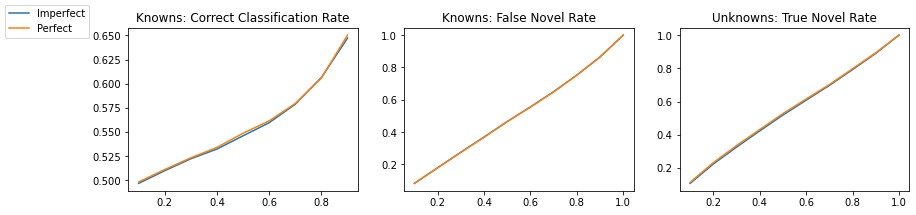

In [20]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

ax1.plot(thresholds, np.mean(imp_known_correct_all, axis = 0), label = 'Imperfect')
ax1.plot(thresholds, np.mean(per_known_correct_all, axis = 0), label = 'Perfect')


ax2.plot(thresholds, np.mean(imp_known_novel_all, axis = 0), label = 'Imperfect')
ax2.plot(thresholds, np.mean(per_known_novel_all, axis = 0), label = 'Perfect')

ax3.plot(thresholds, np.mean(imp_unknown_novel_all, axis = 0), label = 'Imperfect')
ax3.plot(thresholds, np.mean(per_unknown_novel_all, axis = 0), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.savefig('PCA_images_cf2_30iter.pdf')
plt.show()

In [19]:
x_train_known_imp.shape

(40000, 128)